# Merge the Causal Graph and the Knowledge graph

1. For each outage, link all the alerts that occurred 1 hour before the start of the outage till the end of the outage to itself. This will link all the alerts that are potentially responsible for the outage.
2. Train random forest where the features are the alerts that were fired and the label is the outage cluster label. This will help in identifying the outage cluster during inference time.

In [9]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from queue import Queue
import random
import numpy as np
import csv
import pickle
from datetime import datetime, timedelta   ## dts creation
from sklearn import feature_selection      ## mutual information
import json

In [2]:
# For each outage with a start and end time, find the alerts that were fired within 1 hour ago of the start of the outage and till the outage persists
def get_alerts_time(start_time, end_time, num):                                           # the input time and the number of different recorded past alert times, we want alerts from
    lst = []
    low = 0
    mx = len(timelist_alerts)
    high = mx
    while(low<high):
        if(timelist_alerts[int((low+high)/2)] > start_time):
            high = int((low+high)/2)
        else:
            low = int((low+high)/2)+1
    
    ind = low-1
    j = 0
    k = 0
    while(j < low-1 and (start_time - timelist_alerts[low-1-j]) < pd.Timedelta(hours=1)):
        lst.append(numberlist_alerts[low - 1 -j])
        while(j<low-1 and timelist_alerts[low-1-j] == timelist_alerts[low-2-j]):
            lst.append(numberlist_alerts[low-2-j])
            j = j + 1
        j = j + 1
        k = k + 1
    
    j = low
    k = 0
    while(j<mx and (end_time - timelist_alerts[j]) > pd.Timedelta(minutes=1)):
        lst.append(numberlist_alerts[j])
        while(j<mx-1 and timelist_alerts[j] == timelist_alerts[j+1]):
            lst.append(numberlist_alerts[j+1])
            j = j + 1
        j = j + 1
        k = k + 1
    return list(set(lst))


# Wrapper function to get the alerts for each outage
def get_alerts_cso(cso, num):
    timestr = adobe_sign_df[adobe_sign_df['cso_number'] == cso]['start_time'].iloc[0]   # gets cso timestr
    timeend = adobe_sign_df[adobe_sign_df['cso_number'] == cso]['end_time'].iloc[0]
    
    timestr = pd.Timestamp(timestr, tz="UTC")
    timeend = pd.Timestamp(timeend, tz="UTC")

    if timestr < timelist_alerts[0]:
        timestr = timelist_alerts[0]
    
    if timeend < timelist_alerts[0]:
        timeend = timelist_alerts[0]
        
    return(get_alerts_time(timestr, timeend, num))

In [3]:
def combine_graphs(show = False):
    G = nx.union(cg, kg)   
    
    # display the combined graph if 'show = True'
    if show:
        edge_labels = dict()
        color_map = []
        edge_color = []
        i = G.nodes(data = True)[1]

        color_map = [i[1]['color'] for i in list(G.nodes(data = True))]
        for i in list(G.edges(data = True)):
            edge_labels[i[0],i[1]] = i[2]['label']
        edge_color = [i[2]['color'] for i in list(G.edges(data = True))]

        plt.figure(1, figsize = (35,35))
        pos = nx.spring_layout(G)
        for i in cg.nodes():
            pos[i][0] = pos[i][0]*0.5 - 0.7
            pos[i][1] = pos[i][1]*0.8

        for i in kg.nodes():
            pos[i][0] = pos[i][0]*0.7 + 0.6
            pos[i][1] = pos[i][1]*0.9
        nx.draw_networkx_nodes(G, pos = pos, node_color = color_map)
        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edges(G, pos, edge_color =  edge_color)
        nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
        plt.show()
    
    return G

In [4]:
def make_cross_edges(no_of_alert_timestamps , G, show = False):
    
    global inc_dict 
    global cross_edges
    global df_rf
    
    # map of incident number to index
    inc_dict = {}
    cross_edges = []
    for i, inc in enumerate(numberlist_alerts):
        inc_dict[str(inc)] = i
    
    alert_id_cg = {v:k for k,v in cg_alert_id.items()}
    alert_ids = [v for k,v in cg_alert_id.items()]
    
    df_rf = pd.DataFrame()
    
    # for each cso, get alert incidents in its neighbourhood
    for i,cso in enumerate(adobe_sign_df['cso_number'].values):
        l = np.zeros(shape=len(alert_ids)+1)
        
        alerts_timeframe = get_alerts_cso(cso, no_of_alert_timestamps)
        for alert in alerts_timeframe:        # append each alert in neighbourhood as cross_edge to a cso 
            alert_id = df_alerts_sorted['alert_id'].iloc[inc_dict[str(alert)]]
            cross_edges.append([alert_id_cg[alert_id], cso])
            l[alert_id_cg[alert_id]] = 1
        
        l[-1] = symptom_cluster[cso + '_sym']
        df_rf = pd.concat([df_rf, pd.DataFrame([l])], axis=0, ignore_index=True)
       
    df_rf.columns = alert_ids + ['cluster_id']
    
    kwargs = {}
    kwargs['label'] = 'caused CSO'
    kwargs['color'] = 'magenta'
    for edge in cross_edges:
        G.add_edge(edge[0], str(edge[1])+'_sym', **kwargs)
        
    # runs if we want to see the graph
    if show:
        edge_labels = dict()
        color_map = []
        edge_color = []

        color_map = [i[1]['color'] for i in list(G.nodes(data = True))]
        for i in list(G.edges(data = True)):
            edge_labels[i[0],i[1]] = i[2]['label']
        edge_color = [i[2]['color'] for i in list(G.edges(data = True))]

        plt.figure(2, figsize = (35,35))
        pos = nx.spring_layout(G)
        for i in cg.nodes():
            pos[i][0] = pos[i][0]*0.5 - 0.7
            pos[i][1] = pos[i][1]*0.8

        for i in kg.nodes():
            pos[i][0] = pos[i][0]*0.7 + 0.6
            pos[i][1] = pos[i][1]*0.9
        nx.draw_networkx_nodes(G, pos = pos, node_color = color_map)
        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edges(G, pos, edge_color =  edge_color)
        nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
        plt.show()

In [14]:

def read_files():
    global df_alerts_sorted, adobe_sign_df, df_alerts_sorted, timelist_alerts, numberlist_alerts, cg, kg, cg_alert_id, symptom_cluster
    
    cg = pickle.load(open(cg_path, 'rb'))
    kg = pickle.load(open(kg_path, 'rb'))
    
    cg_alert_id = nx.get_node_attributes(cg, "alert_id")
    alert_ids = [v for k,v in cg_alert_id.items()]
    
    symptom_cluster = nx.get_node_attributes(kg, "cluster_id")
    
    df_alerts_sorted = pd.read_csv(alerts_csv, index_col=0)
    df_alerts_sorted['created_at'] = pd.to_datetime(df_alerts_sorted['created_at'])
    df_alerts_sorted = df_alerts_sorted[df_alerts_sorted['alert_id'].isin(alert_ids)]
    
    with open(cso_json, 'r') as f:
        data = json.load(f)
    
    cso_data = {'cso_number':[], 'start_time':[], 'end_time':[]}
    for cso, value in data.items():
        cso_data['cso_number'].append(cso)
        cso_data['start_time'].append(value['primaryIncident']['u_cso_started'])
        cso_data['end_time'].append(value['primaryIncident']['u_cso_ended'])

    adobe_sign_df = pd.DataFrame(cso_data)
    
    df_alerts_sorted = df_alerts_sorted.sort_values(by = 'created_at').reset_index(drop=True)
    timelist_alerts = list(df_alerts_sorted['created_at'])
    numberlist_alerts = list(df_alerts_sorted['incident_number'])

In [70]:
cg_path = './causal_graph_data/cg_unweighted_filtered.gpickle'
kg_path = './CSO_data/KG_pickle_clustered.gpickle'

alerts_csv = './Alerts_data/all_alerts_parsed.csv'
cso_xlsx = 'cso_adobe_sign.xlsx'
cso_time_xlsx = 'cso_time_utc.xlsx'

cso_json = './CSO_data/CSO.json'

In [71]:
read_files()

In [72]:
n = 10
k = 4
G = combine_graphs(False)
make_cross_edges(n , G, False)

In [60]:
pickle.dump(G, open('cg_kg.gpickle', 'wb'))

# Train Random Forest for Alerts to Symptom Clusters

In [73]:
df_rf

,0,2,3,4,5,6,9,20,30,33,...,920,922,925,926,927,932,933,934,936,cluster_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0
178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [75]:
X = df_rf.loc[:, df_rf.columns != 'cluster_id']
y = df_rf['cluster_id']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [130]:
len(np.unique(y_train)), len(np.unique(y_test))

46

In [87]:
clf = RandomForestClassifier(max_depth=25, n_estimators=50, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=25, n_estimators=50, random_state=0)

In [88]:
clf.score(X, y)

0.554945054945055

In [89]:
def gen_labels(X, y, k):
    y_pred_prob = clf.predict_proba(X)
    ind = np.argpartition(y_pred_prob, -k)
    top_k_ind = ind[:, -k:]
    
    labels = []
    acc = 0 
    for i in range(len(y)):
        if y.iloc[i] in top_k_ind[i]:
            labels.append(1)
            acc += 1
        else:
            labels.append(0)
    
    return labels, acc/len(labels)

In [90]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [96]:
acc_list = []

# top-k accuracy computation
for i in range(1,11):
    labels, acc = gen_labels(X_test, y_test, k=i)
    acc_list.append(acc)

In [125]:
acc_list

[0.6181818181818182,
 0.6545454545454545,
 0.6727272727272727,
 0.6909090909090909,
 0.7272727272727273,
 0.7818181818181819,
 0.7818181818181819,
 0.7818181818181819,
 0.7818181818181819,
 0.8]

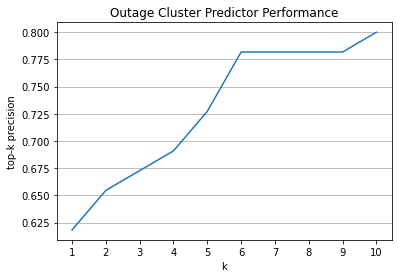

In [122]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(acc_list)+1), acc_list)
plt.xticks(range(1,11))
plt.grid(axis='y')
plt.xlabel('k')
plt.ylabel('top-k precision')
plt.title('Outage Cluster Predictor Performance')
plt.savefig('Outage_Cluster_Predictor.jpg', dpi=400)

In [106]:
a = df_rf['cluster_id'].value_counts()

In [108]:
b = a.sort_index()

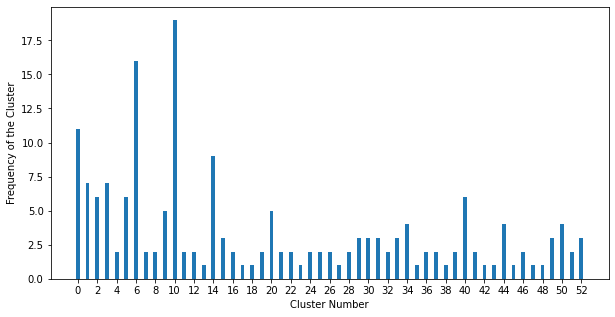

In [124]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(b.index, b, width = 0.4)
plt.xticks(range(0, len(b.index)+1, 2))
plt.xlabel('Cluster Number')
plt.ylabel('Frequency of the Cluster')
plt.savefig('Cluster_Frequency.jpg', dpi=400)

In [30]:
import pickle

In [95]:
pickle.dump(clf, open('random_forest.pickle', 'wb'))

In [129]:
b.sort_values()

42.0     1
18.0     1
17.0     1
35.0     1
23.0     1
13.0     1
43.0     1
38.0     1
45.0     1
47.0     1
48.0     1
27.0     1
51.0     2
21.0     2
25.0     2
24.0     2
28.0     2
37.0     2
22.0     2
36.0     2
26.0     2
16.0     2
39.0     2
41.0     2
12.0     2
11.0     2
8.0      2
7.0      2
46.0     2
4.0      2
19.0     2
32.0     2
49.0     3
52.0     3
31.0     3
30.0     3
29.0     3
15.0     3
33.0     3
34.0     4
50.0     4
44.0     4
9.0      5
20.0     5
40.0     6
5.0      6
2.0      6
3.0      7
1.0      7
14.0     9
0.0     11
6.0     16
10.0    19
Name: cluster_id, dtype: int64